In [2]:
import math
import json
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
#Extract HA1, HA2 seqs from aligned HA

with open('../../seasonal-flu/results/aligned_cdc_h3n2_ha_12y_cell_hi.fasta', "r") as aligned_handle:
    for virus in SeqIO.parse(aligned_handle, "fasta"):
        ha1 = virus.seq[48:1035]
        ha2 = virus.seq[1035:]

In [4]:
#given a polymorphism frequency, return bin
def frequency_binning(x, midfreq_high=0.75, midfreq_low=0.15):
    #nan frequencies are when there is no sequence coverage at the given position
    if math.isnan(x):
        f_bin = float('nan')
    else:
        if x == 1.0:
            f_bin = 'f'
        elif x>=midfreq_high:
            f_bin = 'h'
        elif x<midfreq_high and x>=midfreq_low:
            f_bin = 'm'
        elif x<midfreq_low:
            f_bin='l'

    return f_bin

In [5]:
def walk_through_sites(outgroup_seq, outgroup_aa_seq, input_file_alignment, viruses, midfreq_high, midfreq_low):
    
    #at each site, count number of viruses with polymorphism
    count_polymorphic = np.zeros(len(outgroup_seq))
    #at each site, count totaly number of viruses
    count_total_unambiguous = np.zeros(len(outgroup_seq))
    
    count_replacement_mutations = np.zeros(len(outgroup_seq))
    count_silent_mutations = np.zeros(len(outgroup_seq))
    
    #at each site, list of nucleotide from each virus
    ingroup_bases = [[] for x in range(len(outgroup_seq))]

    with open(input_file_alignment, "r") as aligned_handle:
        for virus in SeqIO.parse(aligned_handle, "fasta"):
            #Only viruses in time window
            if virus.id in viruses:
                #check
                if len(virus.seq) != len(outgroup_seq):
                    print(virus)
                elif len(virus.seq) == len(outgroup_seq): 
                    for pos in range(len(outgroup_seq)):
                        outgroup_nt = str(outgroup_seq[pos])
                        virus_nt = str(virus.seq[pos])
                        #skip ambiguous sites
                        if virus_nt in ['A', 'G', 'C', 'T']:
                            ingroup_bases[pos].append(virus_nt)
                            count_total_unambiguous[pos]+=1
                            if virus_nt != outgroup_nt:
                                count_polymorphic[pos]+=1
                                #determine silent or replacement
                                codon = math.floor(pos/3)
                                codon_pos = pos-(codon*3)
                                if codon_pos == 0:
                                    codon_nt = virus.seq[pos:(pos+3)]
                                elif codon_pos == 1:
                                    codon_nt = virus.seq[(pos-1):(pos+2)]
                                elif codon_pos == 2:
                                    codon_nt = virus.seq[(pos-2):(pos+1)]
                                codon_aa = codon_nt.translate()
                                outgroup_aa = outgroup_aa_seq[codon]
                                if codon_aa != outgroup_aa:
                                    count_replacement_mutations[pos]+=1
                                elif codon_aa == outgroup_aa:
                                    count_silent_mutations[pos]+=1
                                
    polymorphic_frequencies = count_polymorphic/count_total_unambiguous
    
    replacement_score = count_replacement_mutations/count_total_unambiguous

    freq_bins = [frequency_binning(x, midfreq_high, midfreq_low) for x in polymorphic_frequencies]

    return freq_bins, replacement_score, ingroup_bases

In [6]:
def determine_site_type(outgroup, ingroup):
    ingroup_bases_nan = set(ingroup)
    #remove 'nan's
    ingroup_bases = {x for x in ingroup_bases_nan if pd.notna(x)}
    
    if len(ingroup_bases) == 0:
        site_type = None
    
    elif len(ingroup_bases) != 0:
        #all ingroup bases are identical
        if len(ingroup_bases) == 1:
            if outgroup in ingroup_bases:
                site_type = 1
            elif outgroup not in ingroup_bases:
                site_type = 2

        #2 different bases in ingroup
        elif len(ingroup_bases) == 2:
            if outgroup in ingroup_bases:
                site_type = 3
            elif outgroup not in ingroup_bases:
                site_type = 4

        #3 different bases in ingroup
        elif len(ingroup_bases) == 3:
            if outgroup in ingroup_bases:
                site_type = 5
            elif outgroup not in ingroup_bases:
                site_type = 6

        #4 different bases in ingroup
        elif len(ingroup_bases) == 4:
            site_type = 7
    
    return site_type

In [7]:
def fixation_polymorphism_score(outgroup, ingroup):
    site_type = determine_site_type(outgroup, ingroup)
    
    if site_type == None:
        Fi = float('nan')
        Pi = float('nan')
    if site_type == 1:
        Fi = 0
        Pi = 0
    elif site_type == 2:
        Fi = 1
        Pi = 0
    elif site_type in [3,5,7]:
        Fi = 0
        Pi = 1
    elif site_type == 4:
        Fi = 0.5
        Pi = 0.5
    elif site_type == 6:
        Fi = (1/3)
        Pi = (2/3)
    
    return Fi, Pi

In [8]:
def assign_fi_pi(outgroup_seq, ingroup_bases):
    
    #at each site, record Fi
    Fi_all = np.zeros(len(outgroup_seq))
    
    #at each site, record Pi
    Pi_all = np.zeros(len(outgroup_seq))
    
    for pos in range(len(outgroup_seq)):
        outgroup_nt = outgroup_seq[pos]
        ingroup_nts = ingroup_bases[pos]
        Fi, Pi = fixation_polymorphism_score(outgroup_nt, ingroup_nts)
        Fi_all[pos] = Fi
        Pi_all[pos] = Pi
        
    return Fi_all, Pi_all
    
    
                            

In [9]:
def calc_site_stats(window, midfreq_high, midfreq_low):
    #Find percent polymorphism at each site
    #Also determine whether polymorphism is silent or replacement
    input_file_outgroup = '../../seasonal-flu/auspice/flu_seasonal_h3n2_ha_12y_root-sequence.json'
    input_file_alignment = '../../seasonal-flu/results/aligned_cdc_h3n2_ha_12y_cell_hi.fasta'
    metafile = '../../seasonal-flu/results/metadata_h3n2_ha.tsv'

    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    
    #Exclude timepoints earlier than 12y resolution
    meta.drop(meta[meta['year']<2007].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            #non-overlapping
#             date_window_end += window
#             date_window_start+= window
            
            #sliding window
            date_window_end += 1
            date_window_start += 1   
    
    #Find outgroup sequence
    outgroup_seq = ''
    outgroup_aa_seq = ''
    with open(input_file_outgroup, "r") as outgroup_handle:
        outgroup = json.load(outgroup_handle)
        outgroup_seq = SeqRecord(Seq(outgroup['nuc']))
        outgroup_aa_seq = outgroup_seq.translate()
 

    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []
    frequency_bins = []
    fixation_scores = []
    polymorphism_scores = []
    replacement_scores = []
    silent_scores = []    
        
    #each time window separately
    for years, subset_viruses in virus_time_subset.items():
        if len(subset_viruses) != 0:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))
            
            freq_bins, replacement_score, ingroup_bases = walk_through_sites(outgroup_seq, outgroup_aa_seq, 
                                                                             input_file_alignment, subset_viruses,
                                                                             midfreq_high, midfreq_low)
            Fi_all, Pi_all = assign_fi_pi(outgroup_seq, ingroup_bases)
            silent_score = 1-replacement_score
            
            frequency_bins.append(freq_bins)
            fixation_scores.append(Fi_all)
            polymorphism_scores.append(Pi_all)
            replacement_scores.append(replacement_score)
            silent_scores.append(silent_score)
            
    return year_windows, seqs_in_window, frequency_bins, fixation_scores, polymorphism_scores, replacement_scores, silent_scores
            
            


In [10]:
#M=rm/sm 
#not expected to vary through time provided that long-term effective population sizes remain sufficiently large
#For each gene, calculate M by combining site count among time points

def calc_m_ratio(midfreq_high, midfreq_low):

    (year_windows, seqs_in_window, frequency_bins, 
     fixation_scores, polymorphism_scores, 
     replacement_scores, silent_scores) = calc_site_stats('all', midfreq_high, midfreq_low)

    frequency_bins_ha1 = frequency_bins[0][48:1035]
    fixation_scores_ha1 = fixation_scores[0][48:1035]
    polymorphism_scores_ha1 = polymorphism_scores[0][48:1035]
    replacement_scores_ha1 = replacement_scores[0][48:1035]
    silent_scores_ha1 = silent_scores[0][48:1035]
    
    sm = 0
    rm = 0
    
    for site in range(len(frequency_bins_ha1)):
        freq_bin = frequency_bins_ha1[site]
        if freq_bin == 'm':
            sm+= (polymorphism_scores_ha1[site]*silent_scores_ha1[site])
            rm+= (polymorphism_scores_ha1[site]*replacement_scores_ha1[site])
    
    m_ratio = rm/sm
    
    return m_ratio

In [11]:
def bhatt_estimators(window, midfreq_high, midfreq_low):
    (year_windows, seqs_in_window, frequency_bins, 
     fixation_scores, polymorphism_scores, 
     replacement_scores, silent_scores) = calc_site_stats(window, midfreq_high, midfreq_low)
    
    m_ratio = calc_m_ratio(midfreq_high, midfreq_low)
    
    #Initiate lists to store a values
    window_midpoint = []
    adaptive_substitutions = []
    
    #for each window, calculate bhatt estimators 
    for years_window in range(len(frequency_bins)):
        #don't use windows with fewer than 5 sequences
        if seqs_in_window[years_window] >= 5:
            window_start = int(year_windows[years_window][0:4])
            window_end = int(year_windows[years_window][-4:])
            window_midpoint.append((window_start + window_end)/2)

            sf = 0
            rf = 0
            sh = 0
            rh = 0
            sm = 0
            rm = 0
            sl = 0
            rl = 0

            #calculate number of sites in different catagories (defined by polymorphic freq at that site)
            window_freq_bins = frequency_bins[years_window]
            for site in range(len(window_freq_bins)):
                freq_bin = window_freq_bins[site]
                #ignore sites with no polymorphisms?
                if freq_bin!='nan':
                    if freq_bin == 'f':
                        sf+= (fixation_scores[years_window][site]*silent_scores[years_window][site])
                        rf+= (fixation_scores[years_window][site]*replacement_scores[years_window][site])
                    elif freq_bin == 'h':
                        sh+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                        rh+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])
                    elif freq_bin == 'm':
                        sm+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                        rm+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])
                    elif freq_bin == 'l':
                        sl+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                        rl+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])       
                        
#             print(year_windows[years_window])
#             print(sf, rf, sh, rh, sm, rm, sl, rl)  

            #Calculate equation 1: number of nonneutral sites
            al = rl - sl*m_ratio
            ah = rh - sh*m_ratio
            af = rf - sf*m_ratio
            #set negative a values to zero
            if al < 0:
                al = 0
            if ah < 0:
                ah = 0
            if af < 0:
                af = 0

#             print(al, ah, af)

            #Calculate the number and proportion of all fixed or high-freq sites that have undergone adaptive change
            number_adaptive_substitutions = af + ah
            adaptive_substitutions.append(number_adaptive_substitutions)
            proportion_adaptive_sites = (af + ah)/(rf +rh)
            
    return window_midpoint, adaptive_substitutions
    # get coeffs of linear fit
#     slope, intercept, r_value, p_value, std_err = stats.linregress(window_midpoint, adaptive_substitutions)
    
#     ax = sns.regplot(x= window_midpoint, y=adaptive_substitutions, 
#                      line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
#     plt.ylabel('number of adaptive substitutions')
#     plt.xlabel('year')
    
#     ax.legend()
#     plt.show()
        

In [12]:
def plot_bhatt(window, midfreq_high, midfreq_low):
    window_midpoint, adaptive_substitutions = bhatt_estimators(window, midfreq_high, midfreq_low)
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(window_midpoint, adaptive_substitutions)
    
    ax = sns.regplot(x= window_midpoint, y=adaptive_substitutions, 
                     line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.ylabel('number of adaptive substitutions')
    plt.xlabel('year')
    
    ax.legend()
    plt.show()
    

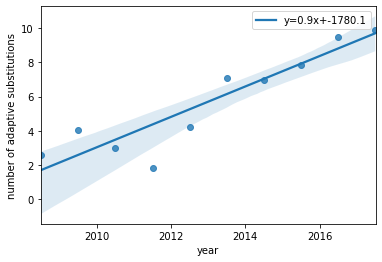

In [13]:
plot_bhatt(3, 0.75, 0.15)